In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [ ]:
!pip install evaluate

In [ ]:
import os
import torch
import pandas as pd
import json
import warnings
from datasets import load_dataset
from datasets import load_from_disk
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
import evaluate

In [ ]:
dataset = load_dataset("Tonic/medquad", split="train")
shuffled_dataset = dataset.shuffle(seed=42)
test_dataset = shuffled_dataset.select(range(300))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Assuming `dataset` is your dataset containing the 'text' feature
instructions_list = []

for row in test_dataset['text']:
    # Split the text based on the '### Assistant:' keyword
    parts = row.split('### Assistant:')

    # Extract the instruction part (assuming it's before '### Assistant:')
    if len(parts) > 0:
        instruction = parts[0].strip()
        instructions_list.append(instruction)

# Print the extracted instructions
# for instruction in instructions_list:
#     print(instruction)



In [ ]:
!pip install rouge_score

In [ ]:
pip install sacremoses

In [ ]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, logging
from evaluate import load
import gc

# Load metrics
rouge = load('rouge')
perplexity = load("perplexity", module_type="metric")

logging.set_verbosity(logging.CRITICAL)

def clear_gpu():
    torch.cuda.empty_cache()
    gc.collect()
    print("GPU cache cleared")

def process_and_compute_metrics_on_cpu(model_name, test_dataset, instructions_list):
    # Explicitly set the device to CPU and retry the metrics computation
    device = "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=-1, max_length=200)

    responses = []
    for instruction in instructions_list:
        result = pipe(f"<s>[INST] {instruction} [/INST]")
        responses.append(result[0]['generated_text'])

    captured_sentences = []
    for sentence in responses:
        inst_index = sentence.find('[/INST]')
        if inst_index != -1:
            captured_text = sentence[inst_index + len('[/INST]'):]
            captured_sentences.append(captured_text)

    responses_list = [row.split('### Response:')[1].strip() if '### Response:' in row else "" for row in test_dataset['text']]
    rouge_results = rouge.compute(predictions=captured_sentences, references=responses_list)
    perplexity_results = perplexity.compute(model_id=model_name, add_start_token=False, predictions=instructions_list)

    del model, tokenizer
    clear_gpu()

    return rouge_results, perplexity_results

def process_and_compute_metrics(model_name, test_dataset, instructions_list):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        return process_metrics(model_name, test_dataset, instructions_list, device)
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print(f"Switching to CPU due to CUDA out of memory error for model {model_name}")
            return process_and_compute_metrics_on_cpu(model_name, test_dataset, instructions_list)
        else:
            raise e

def process_metrics(model_name, test_dataset, instructions_list, device):
    # This part of the code is shared and can be called with either GPU or CPU as device
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0 if device == "cuda" else -1, max_length=200)

    responses = []
    for instruction in instructions_list:
        result = pipe(f"<s>[INST] {instruction} [/INST]")
        responses.append(result[0]['generated_text'])

    captured_sentences = []
    for sentence in responses:
        inst_index = sentence.find('[/INST]')
        if inst_index != -1:
            captured_text = sentence[inst_index + len('[/INST]'):]
            captured_sentences.append(captured_text)

    responses_list = [row.split('### Response:')[1].strip() if '### Response:' in row else "" for row in test_dataset['text']]
    rouge_results = rouge.compute(predictions=captured_sentences, references=responses_list)
    perplexity_results = perplexity.compute(model_id=model_name, add_start_token=False, predictions=instructions_list)

    del model, tokenizer
    clear_gpu()

    return rouge_results, perplexity_results

#model_list = ['microsoft/biogpt', 'yashkeswani/biogpt-finetune', 'Sidsky08/Llama-2-7b-chat-finetune17k']
model_list = ['microsoft/biogpt','gpt2','yashkeswani/biogpt-finetune', 'Sidsky08/gpt2-finetune17k',  ]
results_list = []

for model in model_list:
    rouge_results, perplexity_results = process_and_compute_metrics(model, test_dataset, instructions_list)
    results_list.append({
        "model": model,
        "rouge": rouge_results,
        "perplexity": perplexity_results
    })

for result in results_list:
    print(f"Results for {result['model']}:")
    print("ROUGE:", result['rouge'])
    print("Perplexity:", result['perplexity'])


config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/696k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

  0%|          | 0/19 [00:00<?, ?it/s]

GPU cache cleared


  0%|          | 0/19 [00:00<?, ?it/s]

GPU cache cleared


  0%|          | 0/19 [00:00<?, ?it/s]

GPU cache cleared


  0%|          | 0/19 [00:00<?, ?it/s]

GPU cache cleared
Results for microsoft/biogpt:
ROUGE: {'rouge1': 0.01768541312033608, 'rouge2': 0.011603103304694964, 'rougeL': 0.01561723490507735, 'rougeLsum': 0.015997529650434807}
Perplexity: {'perplexities': [42.090084075927734, 49.422149658203125, 43.391876220703125, 50.8962516784668, 34.05250549316406, 55.014827728271484, 112.15406036376953, 29.082801818847656, 34.47142791748047, 50.907344818115234, 68.47189331054688, 73.5352783203125, 60.98518753051758, 77.4073715209961, 39.12989044189453, 48.44633483886719, 68.8077621459961, 73.85755920410156, 27.367618560791016, 33.15699005126953, 32.30831527709961, 56.41474151611328, 38.65911102294922, 98.824462890625, 45.28372573852539, 36.18811798095703, 45.557674407958984, 45.18710708618164, 123.41071319580078, 46.22197341918945, 38.34718322753906, 24.860612869262695, 119.8941879272461, 54.93901062011719, 96.75432586669922, 38.49365234375, 39.093849182128906, 32.75535202026367, 46.79679489135742, 71.21694946289062, 66.19307708740234, 21.

In [ ]:
results_list

[{'model': 'yashkeswani/biogpt-finetune',
  'rouge': {'rouge1': 0.30584181804212635,
   'rouge2': 0.1387353717187791,
   'rougeL': 0.2349273645471212,
   'rougeLsum': 0.23719518851683957},
  'perplexity': {'perplexities': [2.3170828819274902,
    8.147897720336914,
    5.4627685546875,
    4.060263633728027,
    6.254667282104492,
    7.201020240783691,
    2.3265650272369385,
    2.9712541103363037,
    6.602243423461914,
    8.340764045715332,
    2.621795892715454,
    6.256012916564941,
    5.434927940368652,
    5.319349765777588,
    1.7283962965011597,
    6.071394443511963,
    3.1164822578430176,
    1.5033169984817505,
    2.09716534614563,
    5.253039360046387,
    4.450695991516113,
    11.856656074523926,
    2.8021419048309326,
    10.269560813903809,
    8.38046646118164,
    6.407347202301025,
    2.580706834793091,
    3.7098913192749023,
    9.638993263244629,
    4.504226207733154,
    7.308866024017334,
    2.6568355560302734,
    7.06824254989624,
    9.4867563247

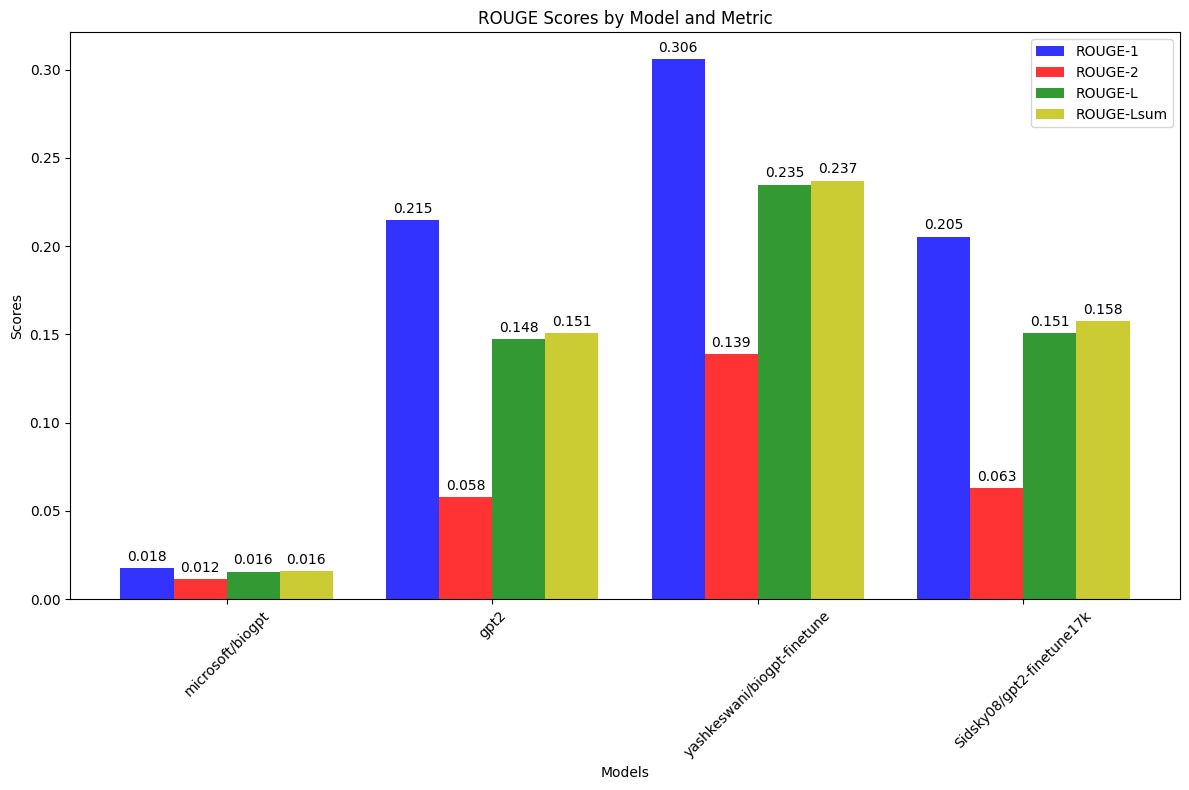

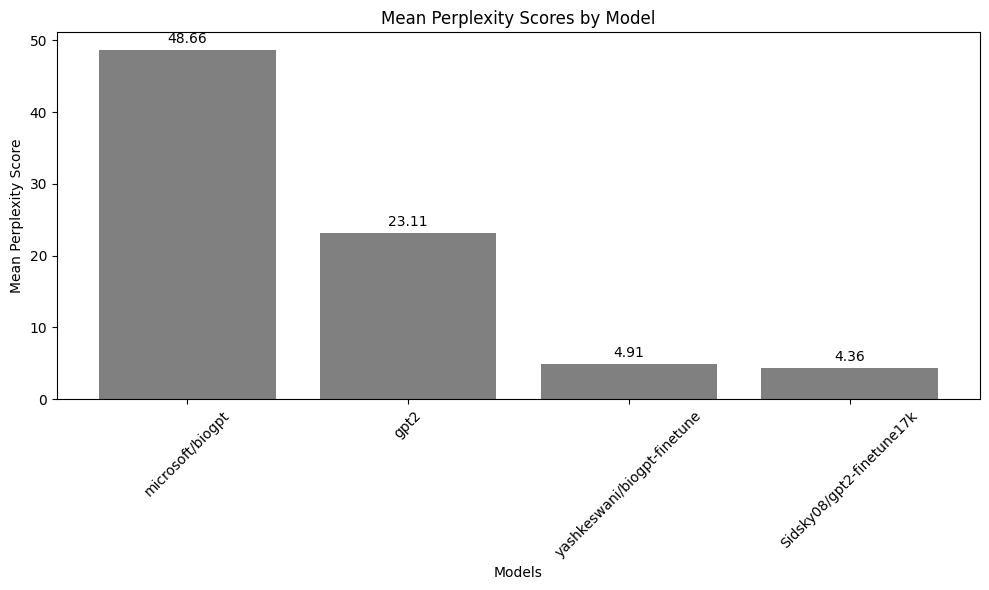

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rouge_metrics(results_list):
    model_names = [result['model'] for result in results_list]
    n_groups = len(results_list)

    rouge1_scores = [result['rouge']['rouge1'] for result in results_list]
    rouge2_scores = [result['rouge']['rouge2'] for result in results_list]
    rougeL_scores = [result['rouge']['rougeL'] for result in results_list]
    rougeLsum_scores = [result['rouge']['rougeLsum'] for result in results_list]

    fig, ax = plt.subplots(figsize=(12, 8))
    index = np.arange(n_groups)
    bar_width = 0.2
    opacity = 0.8

    rects1 = ax.bar(index, rouge1_scores, bar_width, alpha=opacity, color='b', label='ROUGE-1')
    rects2 = ax.bar(index + bar_width, rouge2_scores, bar_width, alpha=opacity, color='r', label='ROUGE-2')
    rects3 = ax.bar(index + 2*bar_width, rougeL_scores, bar_width, alpha=opacity, color='g', label='ROUGE-L')
    rects4 = ax.bar(index + 3*bar_width, rougeLsum_scores, bar_width, alpha=opacity, color='y', label='ROUGE-Lsum')

    # Adding text labels on bars
    for rects in [rects1, rects2, rects3, rects4]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('ROUGE Scores by Model and Metric')
    ax.set_xticks(index + 1.5 * bar_width)
    ax.set_xticklabels(model_names)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_perplexity_metrics(results_list):
    model_names = [result['model'] for result in results_list]
    perplexity_scores = [result['perplexity']['mean_perplexity'] for result in results_list]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, perplexity_scores, color='grey')
    plt.xlabel('Models')
    plt.ylabel('Mean Perplexity Score')
    plt.title('Mean Perplexity Scores by Model')

    # Adding text labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with your existing results_list
plot_rouge_metrics(results_list)
plot_perplexity_metrics(results_list)


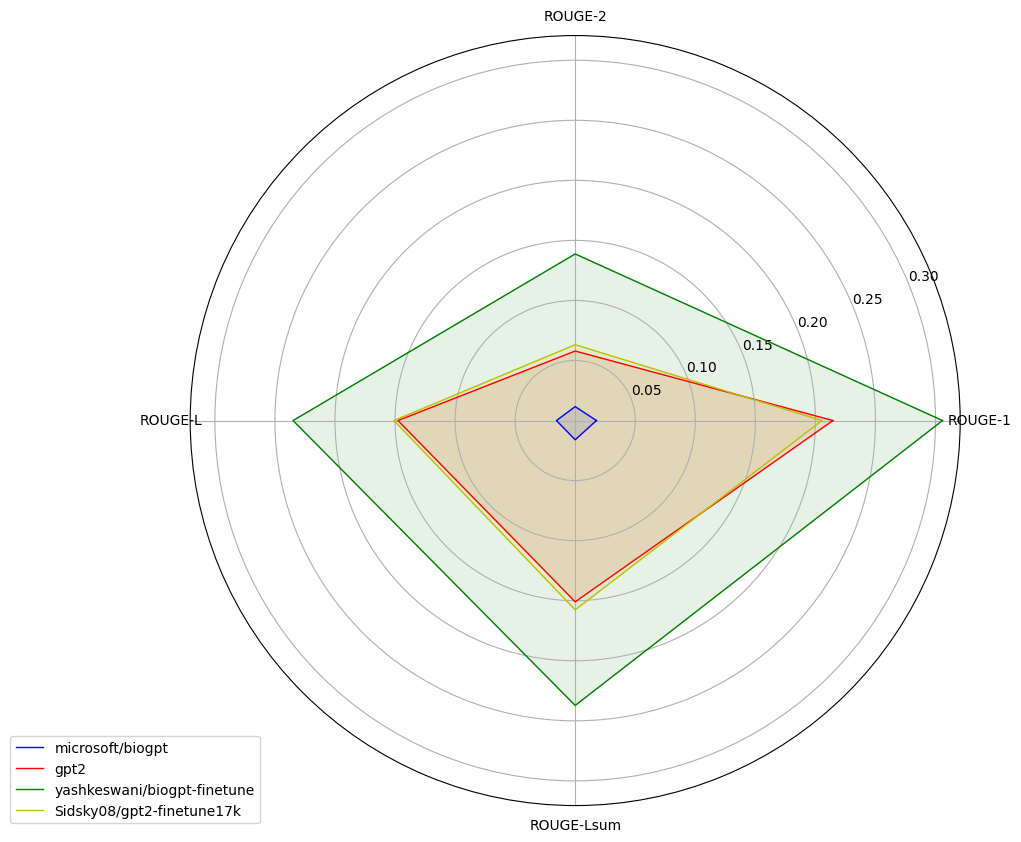

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi

def plot_radar_chart(results_list):
    # Define colors for each model (assuming there are at most 4 models)
    colors = ['b', 'r', 'g', 'y']  # Blue, Red, Green, Yellow
    if len(results_list) > len(colors):
        # Extend the color list with random colors if there are more than four models
        np.random.seed(0)  # For reproducibility
        more_colors = [plt.cm.jet(i) for i in np.linspace(0, 1, len(results_list) - len(colors))]
        colors.extend(more_colors)

    # Create a DataFrame for the data
    categories = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum']
    data = []

    for result in results_list:
        scores = [result['rouge']['rouge1'], result['rouge']['rouge2'], result['rouge']['rougeL'], result['rouge']['rougeLsum']]
        data.append(scores)

    # Create DataFrame
    df = pd.DataFrame(data, columns=categories)
    df['model'] = [result['model'] for result in results_list]

    # Number of variables
    num_vars = len(categories)

    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    for index, (row, color) in enumerate(zip(df.iterrows(), colors)):
        _, row = row
        values = row[categories].values.flatten().tolist()
        values += values[:1]  # Complete the loop
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['model'], color=color)
        ax.fill(angles, values, alpha=0.1, color=color)

    # Labels for each category
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

plot_radar_chart(results_list)


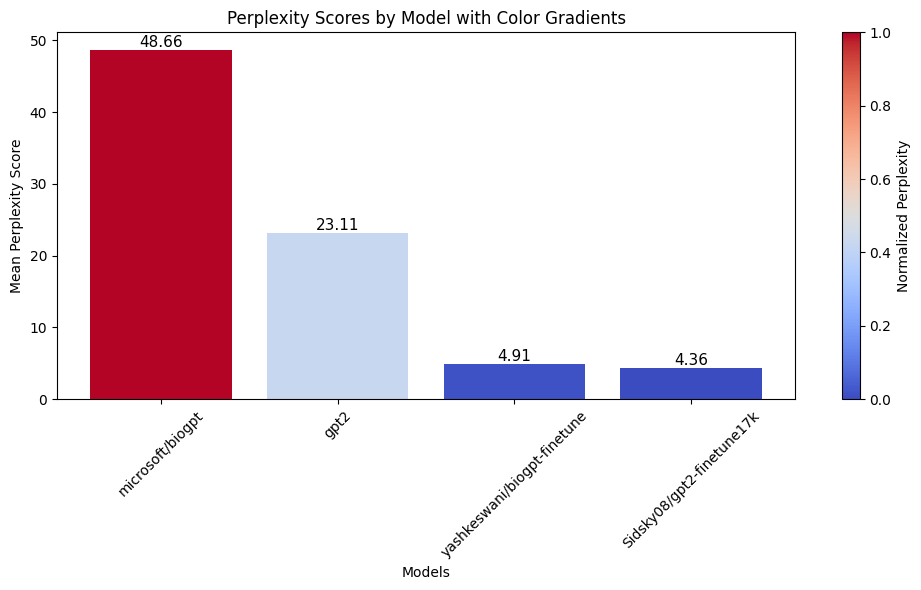

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_perplexity_metrics(results_list):
    model_names = [result['model'] for result in results_list]
    perplexities = [result['perplexity']['mean_perplexity'] for result in results_list]

    # Normalize perplexities for color mapping
    normalized_perplexities = (perplexities - np.min(perplexities)) / (np.max(perplexities) - np.min(perplexities))

    # Set up the color map
    cmap = plt.get_cmap('coolwarm')
    colors = [cmap(x) for x in normalized_perplexities]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, perplexities, color=colors)

    # Adding text labels on bars
    for bar, value in zip(bars, perplexities):
        plt.gca().text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}',
                       ha='center', va='bottom', color='black', fontsize=11)

    plt.xlabel('Models')
    plt.ylabel('Mean Perplexity Score')
    plt.title('Perplexity Scores by Model with Color Gradients')
    plt.xticks(rotation=45)
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), orientation='vertical', label='Normalized Perplexity')
    plt.tight_layout()
    plt.show()

# Example usage with your existing results_list
plot_perplexity_metrics(results_list)


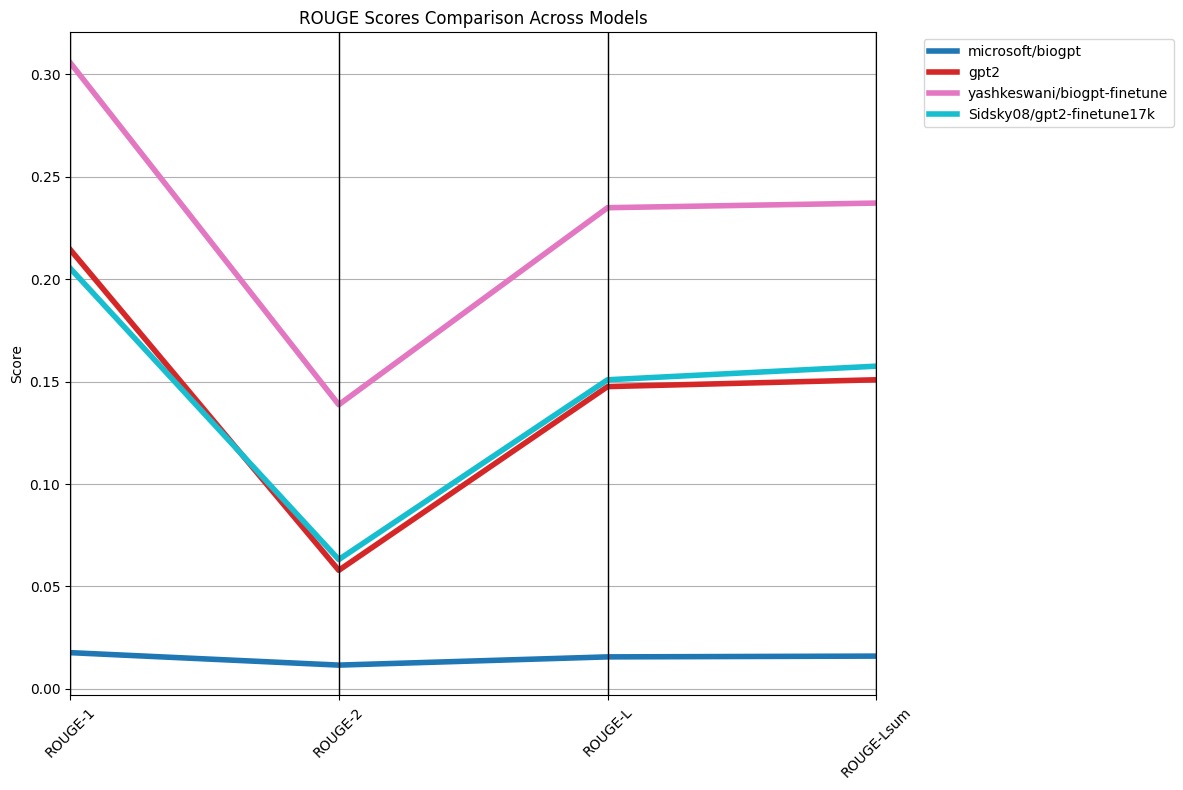

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

def plot_rouge_parallel_coordinates(results_list):
    # Create a DataFrame for the data
    data = {
        'Model': [result['model'] for result in results_list],
        'ROUGE-1': [result['rouge']['rouge1'] for result in results_list],
        'ROUGE-2': [result['rouge']['rouge2'] for result in results_list],
        'ROUGE-L': [result['rouge']['rougeL'] for result in results_list],
        'ROUGE-Lsum': [result['rouge']['rougeLsum'] for result in results_list]
    }
    df = pd.DataFrame(data)

    # Set the 'Model' column as the class column
    fig, ax = plt.subplots(figsize=(12, 8))
    parallel_coordinates(df, class_column='Model', colormap=plt.get_cmap("tab10"), linewidth=4)
    plt.title('ROUGE Scores Comparison Across Models')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage with your existing results_list
plot_rouge_parallel_coordinates(results_list)
